In [1]:
import importlib
import numpy as np

import Parallel_Run
importlib.reload(Parallel_Run)

import matplotlib.pyplot as plt

Ec = lambda L,N : 3/2*np.log(L/N* np.pi/3)
import cProfile
import re


In [48]:
# gillespie parameter
Nlinker = 20
ell_tot = 10**3
kdiff = 0.01
Energy = -15

Nprocess = 100
args = [[ell_tot,Energy,kdiff,np.random.randint(1000000),Nlinker,3] for _ in range(Nprocess)]

# argument of the different classes
cluster_arg = tuple([3.]) # max distance
MSD_arg = () # no argument 
ISF_arg = (0.5,10) # q_norm, q_num_sample
NRG_arg = ()
PCF_arg = (np.sqrt(ell_tot),30) # max_distance,numb_bin
PCF_L_arg = (ell_tot,30) # max_distance,numb_bin

# Simulation parameters
step_tot = 4*10**5
#check_steps = 10**2
initial_check_steps = 10**4
coarse_grained_step = 10**2

In [49]:
log_base = 2
max_exponent = np.log(step_tot / initial_check_steps) / np.log(log_base)
log_check_points = [int(initial_check_steps * log_base ** i) for i in range(int(max_exponent) + 1)]
log_check_points.append(step_tot)
print(log_check_points)

[10000, 20000, 40000, 80000, 160000, 320000, 400000]


In [50]:
#args, step_tot, check_steps,coarse_grained_step,filename,cluster_arg,MSD_arg,ISF_arg,NRG_arg,PCF_arg
Parallel_Run.parallel_evolution(args,step_tot,initial_check_steps,coarse_grained_step,'Test_Real_Sim2.hdf',
                                cluster_arg,MSD_arg,ISF_arg,NRG_arg,PCF_arg,PCF_L_arg)

In [4]:
import Reader
importlib.reload(Reader)
from Reader import CustomHDF5Reader

In [24]:
Read = CustomHDF5Reader('Test_Real_Sim.hdf')
Read.open()
attributes = Read.get_header_attributes()
for key,value in attributes.items():
    print(key + '  '+str(value))
#print(Read.list_groups())
print(Read.list_measurements( Read.list_groups()[0]))
check_time = Read.get_measurement_data(Read.list_groups()[0],'Check_Time')
Read.close()

ell_tot  1000
Energy  -15
kdiff  0.01
seed  819614
Nlinker  20
dimension  3
step_tot  200000
check_steps  10000
coarse_grained_step  100
cluster_max_distance  (3.0,)
MSD_args  ()
ISF_q_norm  (0.2, 10)
ISF_q_num_sample  ()
NRG_args  (31.622776601683793, 30)
PCF_max_distance  (1000, 30)
['Check_Time', 'Coarse_Time', 'ISF', 'MSD', 'MSD_tot', 'NRG', 'PCF', 'PCF_L', 'Time_shift', 'cluster', 'moves_1']


In [25]:
check_time[0]

array([  1.84389737,   3.97125958,   6.36355827,   8.9419316 ,
        11.86526635,  14.43411158,  16.77643496,  19.03604814,
        21.32008932,  24.58864819,  26.99478291,  28.73042991,
        31.12618591,  33.41856987,  36.17625481,  38.70612979,
        40.86039624,  43.42497566,  45.52817343,  48.72201818,
        51.39644115,  53.61835057,  56.05211667,  58.12745481,
        61.00913821,  63.40436242,  66.08527989,  69.02026462,
        71.12765117,  73.18770254,  75.91473291,  78.66383253,
        81.89722806,  84.35319794,  87.01789691,  89.11495159,
        91.41664913,  93.93257813,  96.51868453,  98.60964221,
       101.3287826 , 103.76653698, 106.21617611, 108.21446094,
       111.01940446, 113.65940645, 116.22751806, 118.76087859,
       121.94933735, 124.31369108, 126.21630334, 129.37361023,
       131.60730123, 134.15831063, 136.45490616, 139.64699857,
       141.83317051, 144.21576272, 147.09453097, 149.89648993,
       153.14924239, 155.35971926, 157.53396518, 160.33

In [26]:
import Data_Treatement
importlib.reload(Data_Treatement)
from Data_Treatement import *

In [53]:
data = Data_Treatement('Test_Real_Sim2.hdf',"ISF")
data.average()
#data2 = Data_Treatement('Test.hdf',"cluster")
#print(len(data2.time.shape))

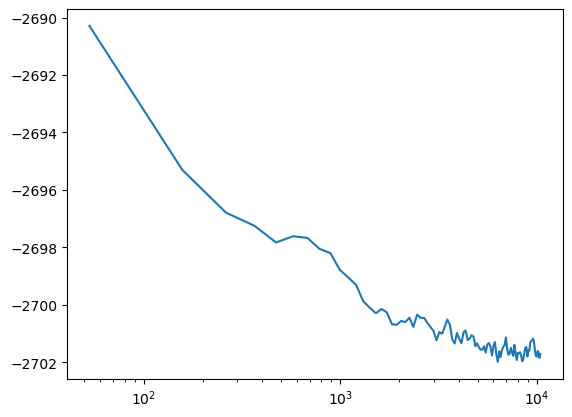

In [52]:
plt.plot(data.binned_time,data.average_data)
plt.xscale('log')

(0.1, 1)

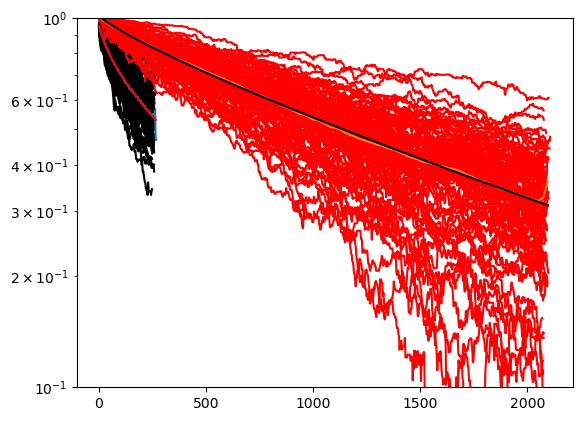

In [68]:
for i in range(100):#data.data.shape[0]):
    plt.plot(data.time[i][0],data.data[i][0],color='black')
for i in range(100):#data.data.shape[0]):
    plt.plot(data.time[i][-1],data.data[i][-1],color='red')
plt.plot(data.binned_time[0],data.average_data[0])
plt.plot(data.binned_time[-1],data.average_data[-1])
from scipy.optimize import curve_fit
def exp_func(x, a, b,alpha):
    return a * np.exp(b* x**alpha)
params0, covariance0 = curve_fit(exp_func, data.binned_time[0],data.average_data[0],p0 =(1,10**-4,0.9))
x_model = np.linspace(min(data.binned_time[0]), max(data.binned_time[0]), 100) # Generate x-values for plotting the fitted curve
y_model = exp_func(x_model, *params0) # Calculate y-values using the fitted parameters
plt.plot(x_model, y_model, label='Fitted Exponential Curve', color='red')
params_1, covariance = curve_fit(exp_func, data.binned_time[-1],data.average_data[-1],(1,10**-4,0.9))
x_model = np.linspace(min(data.binned_time[-1]), max(data.binned_time[-1]), 100) # Generate x-values for plotting the fitted curve
y_model = exp_func(x_model, *params_1) # Calculate y-values using the fitted parameters
plt.plot(x_model, y_model, label='Fitted Exponential Curve', color='black')



plt.yscale('log')
#plt.xscale('log')
plt.ylim(0.1,1)
#plt.savefig('line.svg')

In [70]:
print(params0)
print(params_1)

[ 0.97576831 -0.01615679  0.65170094]
[ 1.0120132  -0.00191294  0.84015194]
